# Exploração dados COVID-19 em Portugal

## Carregar dados com pandas
Fonte: https://github.com/dssg-pt/covid19pt-data

In [110]:
import pandas as pd

DATA_FILEPATH = "https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv"
MEASURES_FILEPATH = "https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/extra/medidas_governamentais/medidas_governamentais.csv"

data_df = pd.read_csv(DATA_FILEPATH, index_col=[0])
data_df = data_df.fillna(value=0) # troca NaN por 0

measures_df = pd.read_csv(MEASURES_FILEPATH, header=None, names = ['data' , 'medida'], index_col=[0])

### Estrutura dos dados

In [131]:
data_df.tail(3)

,data_dados,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,...,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m
data,,,,,,,,,,,,,,,,,,,,,
27-04-2020,27-04-2020 00:00,24027,14496,3252,5556,189,328,120,86,0.0,...,6.0,20.0,28.0,52.0,73.0,111.0,356.0,272.0,468.0,460.0
28-04-2020,28-04-2020 00:00,24322,14702,3289,5593,201,330,121,86,0.0,...,7.0,20.0,30.0,53.0,75.0,112.0,362.0,279.0,479.0,469.0
29-04-2020,29-04-2020 00:00,24505,14715,3340,5695,214,330,125,86,0.0,...,7.0,21.0,31.0,55.0,78.0,113.0,375.0,283.0,496.0,477.0


In [132]:
measures_df.tail(3)

,medida
data,
19-03-2020,Governo define limitações de deslocação e inic...
22-03-2020,Governo determina manutenção do funcionamento ...
23-03-2020,"Ministra da Cultura, Graça Fonseca, afirmou qu..."


### Gráfico com estatísticas gerais

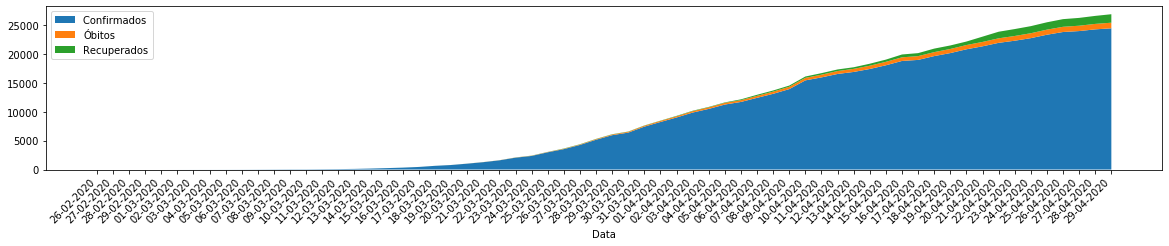

In [108]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import numpy as np

x = data_df.index
y1 = data_df.confirmados
y2 = data_df.obitos
y3 = data_df.recuperados

y = np.vstack([y1, y2, y3])

labels = ["Confirmados ", "Óbitos", "Recuperados"]

fig, ax = plt.subplots()

plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
plt.xlabel("Data")

ax.stackplot(x, y1, y2, y3, labels=labels)
ax.legend(loc='upper left')
plt.show()

### Gráfico com medidas governamentais

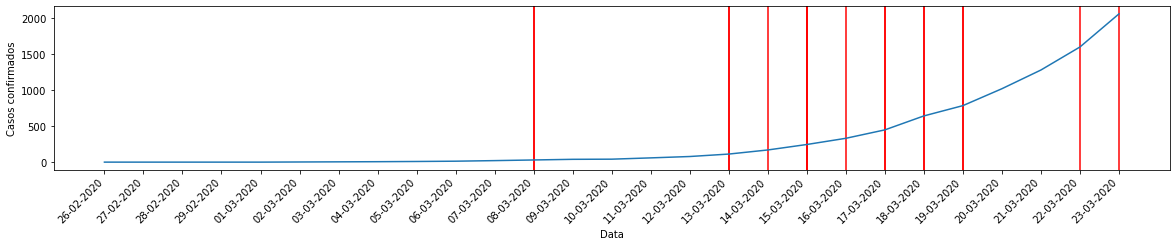

In [130]:
# mostrar mais um bocado depois da última medida
# por legenda das medidas

df = data_df[:measures_df.last_valid_index()] 

x = df.index
y = df.confirmados

fig, ax = plt.subplots()

plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")

plt.xlabel("Data")
plt.ylabel("Casos confirmados")
plt.plot(x,y)

xm = measures_df.index
ax.vlines(xm, 0, 1, transform=ax.get_xaxis_transform(), colors='r')

plt.show()

## Ligação ao QGIS 

In [1]:
from osgeo import ogr
from qgis.core import *
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()

print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/CarlosPeixotoAntunes/AppData/Roaming/python3\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/CarlosPeixotoAntunes/AppData/Roaming/python3\profiles\default/qgis-auth.db



### Carregar layers do mapa mundo
Fontes: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

In [77]:
world = QgsVectorLayer("time_series_covid19_confirmed_global_by_date.geojson","world","ogr")
if not world.isValid():
    print("Layer failed to load!")
else:
    QgsProject.instance().addMapLayer(world)
    print("Layer loaded")
    
countries = QgsVectorLayer("ne_10m_admin_0_countries.shp", "countries", 'ogr')
if not countries.isValid():
    print("Layer failed to load!")
else:
    QgsProject.instance().addMapLayer(countries)
    print("Layer loaded")

Layer loaded
Layer loaded


### Carregar GeoPackage
Fonte: https://github.com/jgrocha/covid-pt     

In [76]:
covid_gpkg = "covid-pt-latest.gpkg" 
conn = ogr.Open(covid_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(covid_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))

Layer concelho loaded
Layer distrito loaded
Layer raa_central_concelho loaded
Layer raa_central_ilha loaded
Layer raa_ocidental_concelho loaded
Layer raa_ocidental_ilha loaded
Layer raa_oriental_concelho loaded
Layer raa_oriental_ilha loaded
Layer ram_concelho loaded
Layer ram_ilha loaded
Layer layer_styles loaded
Layer confirmados_concelho loaded
Layer confirmados_distrito_ilha loaded
Layer situacao_epidemiologica loaded


### Concelhos com mais casos confirmados

In [114]:
concelho = QgsProject.instance().mapLayersByName('concelho')[0]

def confirmados(c):
    con = c["confirmados_concelho_mais_recente"]
    if con == NULL:
        con = 0
    return (c["concelho"], con)

lista = list(map(confirmados, concelho.getFeatures()))
lista.sort(reverse = True, key = lambda c : c[1])

N = 10
print('Concelho -> Casos confirmados')
print('-----------------------------')
for c in lista[:N]:
    print(c[0],' -> ',c[1])

Concelho -> Casos confirmados
-----------------------------
LISBOA  ->  1413
VILA NOVA DE GAIA  ->  1263
PORTO  ->  1211
BRAGA  ->  1019
MATOSINHOS  ->  1017
GONDOMAR  ->  966
MAIA  ->  826
VALONGO  ->  700
SINTRA  ->  568
OVAR  ->  564


### Definição da função de mostrar uma layer em imagem

In [73]:
from IPython.display import Image

def showLayerImage(layer, width, height = 1):

    xt = layer.extent()
    if height == 1:
        height = int(width*xt.height()/xt.width())
    print("Layer: {} ({},{})".format(layer.name(),width, height))
    
    options = QgsMapSettings()
    options.setLayers([layer])
    options.setBackgroundColor(QColor(255, 255, 255))
    options.setOutputSize(QSize(width, height))
    options.setExtent(xt)

    render = QgsMapRendererParallelJob(options)
    render.start()
    render.waitForFinished()

    image = render.renderedImage()
    
    imgbuf = QBuffer()
    imgbuf.open( QIODevice.ReadWrite )
    image.save( imgbuf,"PNG" )
    return Image( imgbuf.data() )

### Mapa do número de casos confirmados por concelho em Portugal

Layer: concelho (200,409)


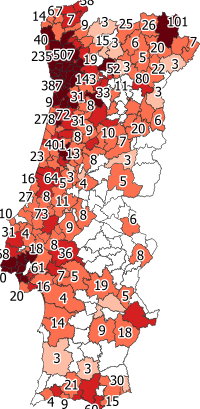

In [74]:
concelho = QgsProject.instance().mapLayersByName('concelho')[0]
showLayerImage(concelho, 200)

Layer: ram_concelho (150,396)


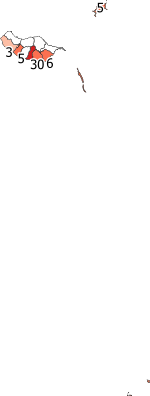

In [115]:
madeira = QgsProject.instance().mapLayersByName('ram_concelho')[0]
showLayerImage(madeira, 150)

Layer: raa_central_concelho (300,151)


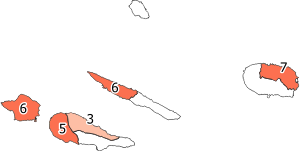

In [59]:
acores = QgsProject.instance().mapLayersByName('raa_central_concelho')[0]
showLayerImage(acores, 300)

Layer: raa_ocidental_concelho (50,128)


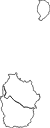

In [60]:
ocidental = QgsProject.instance().mapLayersByName('raa_ocidental_concelho')[0]
showLayerImage(ocidental, 50)

Layer: raa_oriental_concelho (200,283)


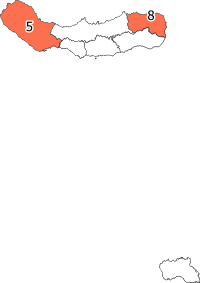

In [62]:
oriental = QgsProject.instance().mapLayersByName('raa_oriental_concelho')[0]
showLayerImage(oriental, 200)

### Mapa mundial

In [31]:
# relação confirmados/pop/testes feitos em relação a portugal

In [ ]:
qgs.exitQgis()